# Model Pipeline

Author: Jasmine Qin  
Date: 2020-05-27

In [1]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import time
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectFromModel

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Evaluation
from sklearn.metrics import plot_confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, r2_score

# Model Explanation
#import eli5
#import shap

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Table of Contents
- [1. Load Data](#ld)
- [2. Summary](#s)
- [3. Feature Engineering](#fe)
- [4. Split Data](#sd)
- [5. Preprocessing](#pp)
- [6. Baseline Model](#bm)
- [7. Feature Importance and Selection](#fi)
- [8. Other Models](#om)
- [9. Hyperparameter Tuning](#ht)
- [10. Other Tests](#ot)

## 1. Load Data <a name="ld"></a>

- Run all scripts 01 to 04 to have the combined and cleaned data
- Load `combined_train.csv` and `combined_validate.csv`

In [5]:
train = pd.read_csv('../../data/processed/04_combined_train.csv',
                    low_memory=False)
#validation = pd.read_csv('../../data/processed/04_combined_validate.csv',
#                         low_memory=False)

In [58]:
#the survisal.csv is the output of 03_clean_licence.py using combined_licence as input 
licence = pd.read_csv('../../data/processed/survisal.csv',
                    low_memory=False)
licence.shape

(693348, 28)

In [64]:
# get the bussiness in 1997 and 2020
business_97 = list(licence[licence['FOLDERYEAR']==1997]['BusinessName'])
business_20 = list(licence[licence['FOLDERYEAR']==2020]['BusinessName'])

In [66]:
#only keeping those that started and failed between 1997 and 2020
licence = licence[~licence['BusinessName'].isin(business_97)]
licence = licence[~licence['BusinessName'].isin(business_20)]

In [67]:
licence.shape

(468880, 28)

In [78]:
licence = licence[licence.BusinessName.notnull()]

In [79]:
licence = licence.sort_values(by=['BusinessName', 'BusinessTradeName', 'FOLDERYEAR', 'ExtractDate'])
licence = licence[licence.groupby(['BusinessName'])['FOLDERYEAR'].apply(
        lambda x: ~(x.duplicated(keep='last')))]

In [80]:
licence.shape

(445815, 28)

In [81]:
#get the number of years each business exists
survived_length = licence.groupby(['BusinessName', 'BusinessTradeName','BusinessType']).count()
#a business can apply for mutiple licence within one year

In [83]:
plot_df = survived_length.groupby('FOLDERYEAR').count()

In [84]:
import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

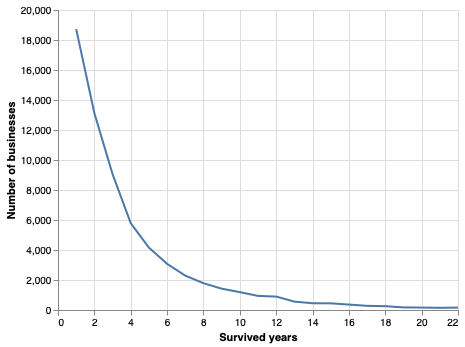

In [95]:
alt.Chart(plot_df.reset_index()).mark_line().encode(
    x=alt.X('FOLDERYEAR:Q',title = 'Survived years'),
    y=alt.Y('business_id:Q', title = 'Number of businesses')
)

In [101]:
dis_park = pd.read_csv('../../data/raw/disability-parking.csv', sep=';')

In [108]:
dis_park['Geom'][1]

'{"type": "Point", "coordinates": [-123.069265, 49.27573]}'

In [0]:
cor_data = (train.drop(columns=['LocalArea','label','BusinessIndustry']).corr().stack()
              .reset_index()     # The stacking results in an index on the correlation values, we need the index as normal columns for Altair
              .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
cor_data['correlation_label'] = cor_data['correlation'].map('{:.2f}'.format)  # Round to 2 decimal
cor_data.head()

,variable,variable2,correlation,correlation_label
0,FOLDERYEAR,FOLDERYEAR,1.000000,1.00
1,FOLDERYEAR,NumberofEmployees,-0.000042,-0.00
2,FOLDERYEAR,FeePaid,0.117842,0.12
3,FOLDERYEAR,Parking meters,0.005132,0.01
4,FOLDERYEAR,Disability parking,0.005770,0.01


In [0]:
base = alt.Chart(cor_data).encode(
    x='variable2:O',
    y='variable:O'    
)

# Text layer with correlation labels
# Colors are for easier readability
text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

# The correlation heatmap itself
cor_plot = base.mark_rect().encode(
    color='correlation:Q'
)

final_plot = cor_plot + text 
save(final_plot,'cor_plot.html')

## 2. Summary <a name="s"></a>

In [0]:
# get categorical and numerical variables
cat_vars = ['FOLDERYEAR', 'BusinessIndustry', 'LocalArea']
#cat_vars = ['BusinessIndustry']
label = ['label']

num_vars = [i for i in train.columns if i not in cat_vars and i not in label]

In [0]:
def describe_data(df, num_vars, cat_vars):
    """
    This function prints shape of the given dataframe
    and returns two separate reports for both 
    numeric and categorical variables.
    """
    
    print("The dataset has", df.shape[0], "rows and", df.shape[1], "columns.\n")
    
    num_summary = df[num_vars].describe()
    num_summary.loc['missing'] = [df[s].isnull().sum() for s in num_vars]
    
    cat_summary = {'cat_var':[], 'missing':[], 'unique':[]}
    for c in cat_vars:
        cat_summary['cat_var'].append(c)
        cat_summary['missing'].append(sum(df[c].isnull()))
        cat_summary['unique'].append(len(df[c].unique()))
    
    return num_summary, pd.DataFrame(cat_summary)

In [0]:
num_df, cat_df = describe_data(train, num_vars, cat_vars)
display(num_df, cat_df)

The dataset has 448011 rows and 104 columns.



,NumberofEmployees,FeePaid,Parking meters,Disability parking,Unemployment_rate,Without children at home,1 child,2 children,3 or more children,English,...,other transportation,Worked at home,Worked at usual place,Worked outside Canada,No fixed workplace,education below postsecondary,education above postsecondary,Non-immigrants,Non-permanent residents,Immigrants
count,1.795020e+05,443599.000000,409894.000000,434145.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,...,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000,448011.000000
mean,6.739126e+04,202.333659,1648.666626,11.186046,6.266494,0.592673,0.198782,0.158850,0.049495,0.560665,...,0.015732,0.092852,0.792807,0.010820,0.103521,0.359783,0.640217,0.547568,0.048296,0.404159
std,2.018491e+07,436.703545,1538.957270,6.840940,1.413287,0.156282,0.038368,0.083252,0.041358,0.140725,...,0.004988,0.028627,0.026758,0.007562,0.021872,0.139427,0.139427,0.098328,0.030938,0.101331
min,0.000000e+00,-940.000000,7.000000,1.000000,4.000000,0.303209,0.118407,0.043171,0.006378,0.256763,...,0.003484,0.033845,0.676393,0.000000,0.041667,0.138569,0.005047,0.310705,0.008676,0.256277
25%,1.000000e+00,100.000000,280.000000,5.000000,4.700000,0.408842,0.173055,0.087394,0.015099,0.459787,...,0.011740,0.077628,0.784780,0.005785,0.086070,0.237883,0.544681,0.504460,0.023744,0.321346
50%,2.000000e+00,126.000000,940.000000,10.000000,6.600000,0.657711,0.189055,0.122388,0.026539,0.570918,...,0.015165,0.101322,0.792766,0.008735,0.100564,0.340364,0.659636,0.542273,0.037511,0.390754
75%,6.000000e+00,166.000000,3771.000000,19.000000,7.200000,0.730159,0.232658,0.255413,0.078853,0.648828,...,0.018963,0.105563,0.809569,0.014189,0.119759,0.455319,0.762117,0.629853,0.064937,0.462656
max,6.047106e+09,33155.000000,3771.000000,19.000000,8.800000,0.824004,0.305720,0.308194,0.203310,0.792318,...,0.041005,0.205570,0.868699,0.049089,0.166318,0.994953,0.861431,0.719883,0.113870,0.662663
missing,2.685090e+05,4412.000000,38117.000000,13866.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,cat_var,missing,unique
0,FOLDERYEAR,0,23
1,BusinessIndustry,0,15
2,LocalArea,0,22


In [0]:
train['label'].value_counts()

1    375350
0     72661
Name: label, dtype: int64

## 3. Feauture Engineering <a name="fe"></a>

- Including just cleaning for now, other steps to add in the future
- Will be moved to a separate feature engineering script

In [0]:
def feature_engineering(df):
    df = df[df.LocalArea.notnull()]
    #df = df[df.Status == 'Issued']

    df = df[num_vars+cat_vars+label]
    return df.drop(columns=label), df['label']


## 4. Split Data <a name="sd"></a>


- Split data here because Validation set is used directly as Test

In [0]:
X_train_valid, y_train_valid = feature_engineering(train)
#X_test, y_test = feature_engineering(validation)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=2020)

## 5. Preprocessing <a name="pp"></a>

- include polynomial features (interactions, e.g., local area x business type)

In [0]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',
                              fill_value='missing')),
    ('onehot', OneHotEncoder(
        handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

## 6. Baseline Model <a name="bm"></a>

[ROC AUC](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation) source

In [0]:
def evaluate_model(model, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid, verbose=True):
    """
    This function prints train and test accuracies,
    classification report, and confusion matrix.
    """
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    if verbose:
        print("Train Accuracy:", train_acc)
        print("Validation Accuracy", test_acc, "\n")

        print(classification_report(y_test, model.predict(X_test)))
        print(plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=[0, 1],
                                     cmap=plt.cm.Blues,
                                     values_format='d'))
    else:
        report = {}
        f1 = f1_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        report['renewed'] = [f1, recall, precision]
        
        f1 = f1_score(y_test, model.predict(X_test), pos_label=0)
        recall = recall_score(y_test, model.predict(X_test), pos_label=0)
        precision = precision_score(y_test, model.predict(X_test), pos_label=0)
        report['not_renewed'] = [f1, recall, precision]
        
        report['accuracy'] = [train_acc, test_acc]
        
        return report

In [0]:
def roc_curve_auc(model, X_train=X_train, X_test=X_valid, y_train=y_train, y_test=y_valid):
    """
    This function plots ROC curve and prints AUC score.
    """
    # assume fit model first
    #mode.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        
    fig = plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr)
    plt.plot((0,1),(0,1),'--k')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.annotate(f'AUC score = {auc: .4f}', (0.0, 0.9))

The max_iter was reached which means the coef_ did not converge


Train Accuracy: 0.5681653311310015
Validation Accuracy 0.5681506199569211 

              precision    recall  f1-score   support

           0       0.19      0.53      0.28     14416
           1       0.87      0.58      0.69     75187

    accuracy                           0.57     89603
   macro avg       0.53      0.55      0.49     89603
weighted avg       0.76      0.57      0.63     89603



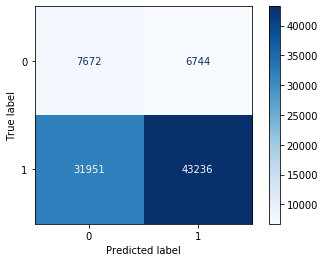

In [0]:
lr = LogisticRegression(solver='saga', class_weight='balanced')

lr_pip = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', lr)])

evaluate_model(lr_pip)

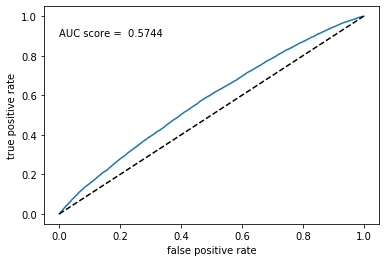

In [0]:
roc_curve_auc(lr_pip)

## 7. Feature Importance and Selection <a name="fi"></a>

- weights
- RFE
- L1, L2
- PCA

In [0]:
def explain_model(pip, df, verbose=True):
    pp1_features = num_vars + \
        list(pip['preprocessor'].transformers_[
             1][1]['onehot'].get_feature_names())
    
    return eli5.show_weights(pip['classifier'],
                             feature_names=pp1_features,
                             top=30)


In [0]:
explain_model(lr_pip, X_train)

Weight?,Feature
+0.586,x1_Health care and social assistance
+0.382,x1_Finance and insurance
+0.139,x0_2001
+0.129,x1_Manufacturing
+0.071,age above 60
+0.069,x0_2000
+0.069,Health
+0.066,x0_2009
+0.065,x0_2002
+0.064,x1_Other services (except public administration)


In [0]:
len(X_train.columns)

103

In [0]:
rfe_train = X_train.drop(columns=['BusinessIndustry', 'LocalArea'])
rfe_train['label']=y_train
rfe_train.dropna(inplace=True)
rfe_label = rfe_train['label']
rfe_train.drop(columns=['label'],inplace=True)

In [0]:
rfe_train = preprocessor.fit_transform(X_train)


In [0]:
lr = LogisticRegression(solver='saga', class_weight='balanced', penalty ='l1',max_iter=2000)
rfe = RFE(estimator = lr, n_features_to_select = 50, step = 10)
rfe.fit(rfe_train, y_train)
rfe_train_sel = rfe_train.iloc[:, rfe.support_]

In [0]:
print(rfe.ranking_)
print('The relevant features are'+str(list(rfe_train_sel.columns)))

## 8. Other Models <a name="om"></a>

Train Accuracy: 0.594227807415013
Validation Accuracy 0.5879490642054396 

              precision    recall  f1-score   support

           0       0.21      0.58      0.31     14416
           1       0.88      0.59      0.71     75187

    accuracy                           0.59     89603
   macro avg       0.55      0.58      0.51     89603
weighted avg       0.77      0.59      0.64     89603



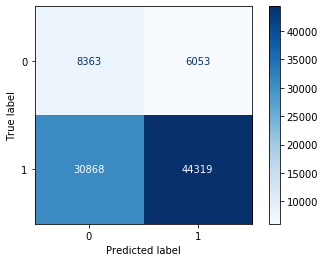

In [0]:
lgbm = LGBMClassifier(class_weight='balanced')

lgbm_pip = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgbm)])

evaluate_model(lgbm_pip)

In [0]:
roc_curve_auc(lgbm_pip)

In [0]:
explain_model(lgbm_pip, X_train)

Train Accuracy: 0.8011488750598372
Validation Accuracy 0.7982388973966309 

              precision    recall  f1-score   support

           0       0.50      0.00      0.00       527
           1       0.80      1.00      0.89      2085

    accuracy                           0.80      2612
   macro avg       0.65      0.50      0.45      2612
weighted avg       0.74      0.80      0.71      2612



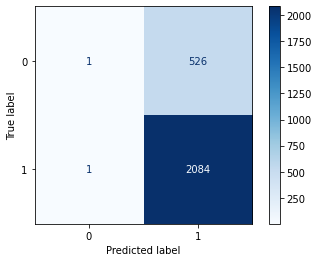

In [17]:
xgboost = XGBClassifier(objective="binary:logistic", random_state=42)

xg_pip = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgboost)])

evaluate_model(xg_pip)

In [0]:
roc_curve_auc(lgbm_pip)

In [18]:
#use ensemble
classifiers_e = {
    "KNN"                   : KNeighborsClassifier(),
    "Naive Bayes"           : GaussianNB(),
    "Logistic Regression"   : LogisticRegression(solver='saga', class_weight='balanced'),
    "SVM"                   : SVC(probability=True)
}


ensemble = VotingClassifier(classifiers_e.items(), voting="soft")
voting_pip = Pipeline(steps=[('preprocessor', preprocessor),
                             ('smote', SMOTE(sampling_strategy=0.85)),
                           ('classifier', ensemble)])
evaluate_model(voting_pip)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


KeyboardInterrupt: ignored

## 9. Hyperparameter Tuning <a name="ht"></a>

- regularization strength
- tree max depth
- sampling strategy for SMOTE
- missing value imputing strategy
- degree of polynomial terms

In [0]:
lrhp = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LGBMClassifier(class_weight='balanced'))])

param_grid = {
    'classifier__reg_lambda': [0.1, 1],
}

#gs = GridSearchCV(lrhp, param_grid, cv=5, scoring='f1')
#gs.fit(X_train, y_train);

## 10. Other Tests <a name="ot"></a>

- SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Accuracy: 0.8195308760172332
Validation Accuracy 0.7522970903522205 

              precision    recall  f1-score   support

           0       0.31      0.19      0.23       527
           1       0.81      0.90      0.85      2085

    accuracy                           0.75      2612
   macro avg       0.56      0.54      0.54      2612
weighted avg       0.71      0.75      0.73      2612



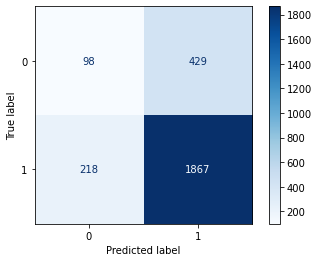

In [29]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
smote_pip = Pipeline(steps=[('preprocessor', preprocessor),
                            ('smote', SMOTE(sampling_strategy=0.85)),
                            ('classifier', LGBMClassifier(class_weight='balanced'))])

#param_grid = {
#    'smote__sampling_strategy': [0.1, 0.5, 0.8, 1.0],
#}

#gs = GridSearchCV(smote_pip, param_grid, cv=5, scoring='f1')
#gs.fit(X_train_valid, y_train_valid)
evaluate_model(smote_pip)

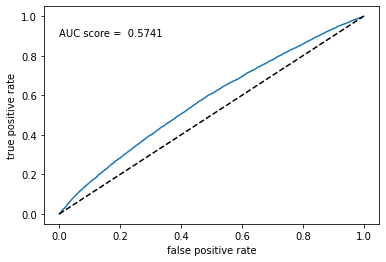

In [32]:
roc_curve_auc(smote_pip)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Accuracy: 0.7988511249401627
Validation Accuracy 0.7534456355283308 

              precision    recall  f1-score   support

           0       0.32      0.19      0.24       527
           1       0.81      0.89      0.85      2085

    accuracy                           0.75      2612
   macro avg       0.57      0.54      0.55      2612
weighted avg       0.71      0.75      0.73      2612



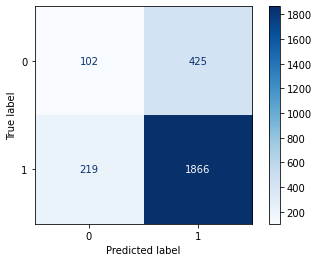

In [20]:
smote_pip = Pipeline(steps=[('preprocessor', preprocessor),
                            ('smote', SMOTE(sampling_strategy=0.85)),
                            ('classifier',  LGBMClassifier(boosting_type='dart',class_weight='balanced'))])

#param_grid = {
#    'smote__sampling_strategy': [0.1, 0.5, 0.8, 1.0],
#}

#gs = GridSearchCV(smote_pip, param_grid, cv=5, scoring='f1')
#gs.fit(X_train_valid, y_train_valid)
evaluate_model(smote_pip)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Accuracy: 0.820009573958832
Validation Accuracy 0.7545941807044411 

              precision    recall  f1-score   support

           0       0.34      0.22      0.27       527
           1       0.82      0.89      0.85      2085

    accuracy                           0.75      2612
   macro avg       0.58      0.55      0.56      2612
weighted avg       0.72      0.75      0.73      2612



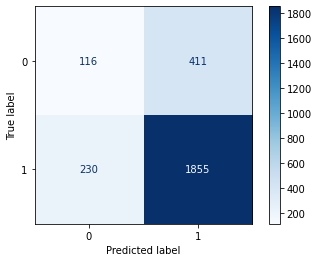

In [26]:
smote_pip = Pipeline(steps=[('preprocessor', preprocessor),
                            ('smote', SMOTE(sampling_strategy=0.75)),
                            ('classifier',  LGBMClassifier(class_weight='balanced'))])
evaluate_model(smote_pip)

#hyperparameter tuning


In [21]:
#use l1 to drop out some variables
lrhp = Pipeline(steps=[('preprocessor', preprocessor),
                       ('smote', SMOTE(sampling_strategy=0.85)),
                       ('classifier', LGBMClassifier(class_weight='balanced'))])

param_grid = {
    'classifier__reg_alpha': [0.1, 0.3, 0.5],
}

gs = GridSearchCV(lrhp, param_grid, cv=5, scoring='f1')
gs.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                    

In [22]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Accuracy: 0.8197223551938727
Validation Accuracy 0.7572741194486983 

              precision    recall  f1-score   support

           0       0.32      0.19      0.24       527
           1       0.81      0.90      0.86      2085

    accuracy                           0.76      2612
   macro avg       0.57      0.54      0.55      2612
weighted avg       0.72      0.76      0.73      2612



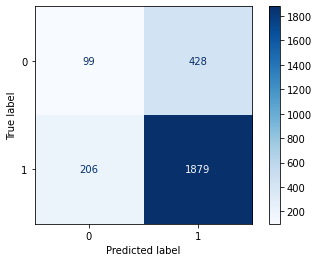

In [24]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
smote_lg_pip = Pipeline(steps=[('preprocessor', preprocessor),
                            ('smote', SMOTE(sampling_strategy=0.85)),
                            ('classifier', LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.5,
                                reg_lambda=0.0, silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))])

evaluate_model(smote_lg_pip)

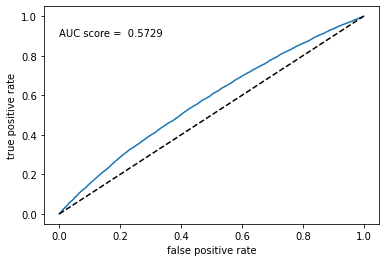

In [34]:
roc_curve_auc(smote_lg_pip)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Accuracy: 0.7898516036381044
Validation Accuracy 0.776416539050536 

              precision    recall  f1-score   support

           0       0.34      0.12      0.18       527
           1       0.81      0.94      0.87      2085

    accuracy                           0.78      2612
   macro avg       0.58      0.53      0.52      2612
weighted avg       0.72      0.78      0.73      2612



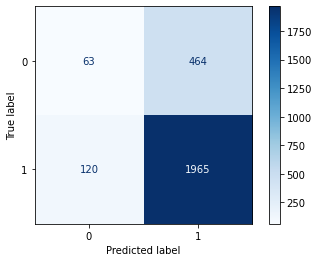

In [12]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
xgboost = XGBClassifier(objective="binary:logistic", random_state=42)

xg_pip = Pipeline(steps=[('preprocessor', preprocessor),
                         ('smote', SMOTE(sampling_strategy=0.85)),
                           ('classifier', xgboost)])

evaluate_model(xg_pip)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Accuracy: 0.7164193393968405
Validation Accuracy 0.5696784073506891 

              precision    recall  f1-score   support

           0       0.23      0.47      0.31       527
           1       0.82      0.60      0.69      2085

    accuracy                           0.57      2612
   macro avg       0.52      0.53      0.50      2612
weighted avg       0.70      0.57      0.61      2612



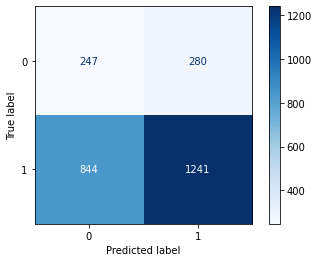

In [19]:
knn =KNeighborsClassifier()

knn_pip = Pipeline(steps=[('preprocessor', preprocessor),
                         ('smote', SMOTE(sampling_strategy=0.85)),
                           ('classifier', knn)])

evaluate_model(knn_pip)

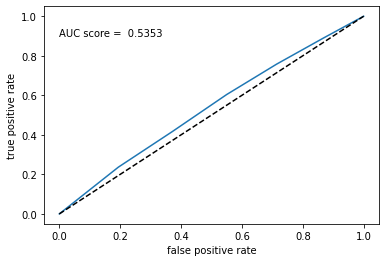

In [35]:
roc_curve_auc(knn_pip)

In [0]:
svm = SVC(probability=True)
svm_pip = Pipeline(steps=[('preprocessor', preprocessor),
                         ('smote', SMOTE(sampling_strategy=0.85)),
                           ('classifier', svm)])

evaluate_model(svm_pip)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
roc_curve_auc(svm_pip)